In [1]:
'''A jupyter notebook detailing the use of the
particle filter to fit a model with a time dependent beta and synthetic data set. 
This one is the same beta for every node. 
'''

'A jupyter notebook detailing the use of the\nparticle filter to fit a model with a time dependent beta and synthetic data set. \nThis one is the same beta for every node. \n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from epymorph.forecasting.likelihood import Poisson,Gaussian,NegativeBinomial
from epymorph.attribute import NamePattern
from epymorph.kit import *

from epymorph.forecasting.pipeline import (
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
    UnknownParam
)

from epymorph.simulation import Context
from epymorph.adrio import acs5, us_tiger
from epymorph.forecasting.param_transformations import ExponentialTransform
from epymorph.forecasting.dynamic_params import GaussianPrior, OrnsteinUhlenbeck

In [3]:
my_rng = np.random.default_rng(1)
'''Generate a random time dependent beta'''
log_beta_damping = 1 / 35
log_beta_mean = np.log(0.5)
log_beta_standard_deviation = 0.30
initial_log_beta = np.log(0.2)

delta_t = 1. 

A = np.exp(-log_beta_damping * delta_t)
M = log_beta_mean * (np.exp(-log_beta_damping * delta_t) - 1)
C = log_beta_standard_deviation * np.sqrt(1-np.exp(-2*log_beta_damping * delta_t))

sim_time_frame = TimeFrame.of("2015-01-01", 365)

log_beta = np.zeros((sim_time_frame.duration_days,))
log_beta[0] = initial_log_beta

for day in range(1,sim_time_frame.duration_days): 
    log_beta[day] = A * log_beta[day-1] - M + C * my_rng.normal()

beta = np.exp(log_beta)

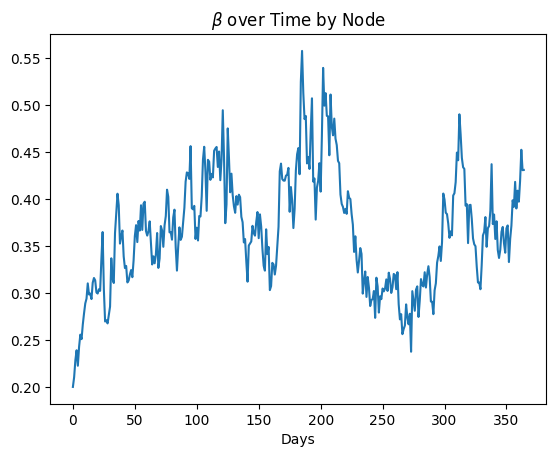

In [4]:
plt.title('$\\beta$ over Time by Node')
plt.xlabel('Days')
plt.plot(beta)

In [5]:


rume = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.SIRH(),
    # Load the Pei MM
    mm=mm.Centroids(),
    # Describe the geographic scope of our simulation:
    scope=CountyScope.in_counties(["King, WA","Whatcom, WA","Pierce, WA","Snohomish, WA"], year=2015),
    # Create a SingleLocation initializer
    init=init.SingleLocation(location=0, seed_size=100),
    # Set the time-frame to simulate
    time_frame=sim_time_frame,
    # Provide model parameter values
    params={
        "beta": beta,
        "gamma":0.1,
        "xi":1/90,
        "phi":5,
        "commuter_proportion":0.35,
        "hospitalization_prob":1/100,
        "hospitalization_duration":5,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

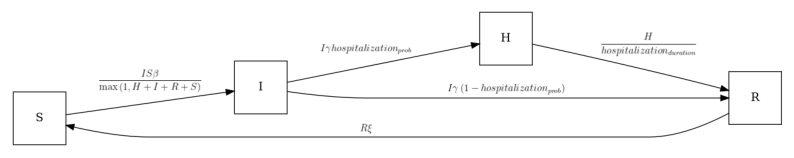

In [6]:
rume.ipm.diagram()

In [7]:

# Construct a simulator for the RUME
sim = BasicSimulator(rume)

# Run inside a sim_messaging context to display a nice progress bar
with sim_messaging():
    # Run and save the simulation Output object for later
    out = sim.run(
        # Use a seeded RNG (for the sake of keeping this notebook's results consistent)
        # This parameter is optional; by default a new RNG is constructed for each run
        # using numpy's default_rng
        rng_factory=default_rng(1)
    )

Loading gpm:all::mm::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (0.625s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-12-31 (365 days)
• 4 geo nodes
  |####################| 100%                     
Runtime: 0.389s


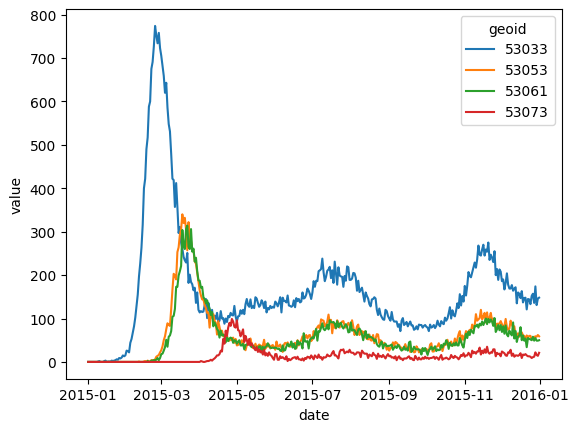

In [8]:
# Plot the compartment values in States throughout the simulation.
from epymorph.adrio import csv
from epymorph.tools.data import munge
import seaborn as sns


cases_df = munge(
    out,
    quantity=rume.ipm.select.events("I->H"),
    time=rume.time_frame.select.all().group("day").agg(),
    geo=rume.scope.select.all(),
)

cases_df.columns = ['date','geoid','value']

sns.lineplot(data=cases_df,x='date',y='value',hue='geoid')

cases_df.to_csv('pf_vignettes/synthetic_data.csv',index=False)

csvadrio = csv.CSVFileAxN(
    file_path='pf_vignettes/synthetic_data.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)


In [ ]:
num_realizations = 100

pf_scope = CountyScope.in_counties(["King, WA","Whatcom, WA","Pierce, WA","Snohomish, WA"],year=2015)

pf_rume = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.SIRH(),
    # Load the Pei MM
    mm=mm.Centroids(),
    # Describe the geographic scope of our simulation:
    scope=pf_scope,
    # Create a SingleLocation initializer
    init=init.RandomLocationsAndRandomSeed(1,1000),
    # Set the time-frame to simulate
    time_frame=sim_time_frame,
    # Provide model parameter values
    params={
        "beta": ExponentialTransform("log_beta"),
        "gamma":0.1,
        "xi":1/90,
        "phi":10,
        "hospitalization_prob":1/100,
        "hospitalization_duration":5,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

my_observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        geo=pf_rume.scope.select.all(),
        time=pf_rume.time_frame.select.all().group("day").agg(),
        quantity=pf_rume.ipm.select.events("I->H"),
    ),
    likelihood=NegativeBinomial(r=50),
)

my_unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=log_beta_damping,
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
    )
}


particle_filter_simulator = ParticleFilterSimulator(
        config=FromRUME(pf_rume,num_realizations,unknown_params = my_unknown_params),
        observations=my_observations,
        save_trajectories=True,
    )


In [10]:
particle_filter_output = particle_filter_simulator.run(rng=my_rng)

Observation: 0, Label: 2015-01-01, Time Frame: 2015-01-01 (1D), 
Observation: 1, Label: 2015-01-02, Time Frame: 2015-01-02 (1D), 
Observation: 2, Label: 2015-01-03, Time Frame: 2015-01-03 (1D), 
Observation: 3, Label: 2015-01-04, Time Frame: 2015-01-04 (1D), 
Observation: 4, Label: 2015-01-05, Time Frame: 2015-01-05 (1D), 
Observation: 5, Label: 2015-01-06, Time Frame: 2015-01-06 (1D), 
Observation: 6, Label: 2015-01-07, Time Frame: 2015-01-07 (1D), 
Observation: 7, Label: 2015-01-08, Time Frame: 2015-01-08 (1D), 
Observation: 8, Label: 2015-01-09, Time Frame: 2015-01-09 (1D), 
Observation: 9, Label: 2015-01-10, Time Frame: 2015-01-10 (1D), 
Observation: 10, Label: 2015-01-11, Time Frame: 2015-01-11 (1D), 
Observation: 11, Label: 2015-01-12, Time Frame: 2015-01-12 (1D), 
Observation: 12, Label: 2015-01-13, Time Frame: 2015-01-13 (1D), 


KeyboardInterrupt: 

In [ ]:

context = Context.of(
    scope=pf_rume.scope,
    # We fetch data starting from the first fitting date to match the first nowcast.
    time_frame=pf_rume.time_frame,
    rng=my_rng,
)
real_data_result = (
    my_observations.source.with_context_internal(context).inspect().result
)
real_data = real_data_result["value"]

real_data_dates = real_data_result["date"][:, 0]

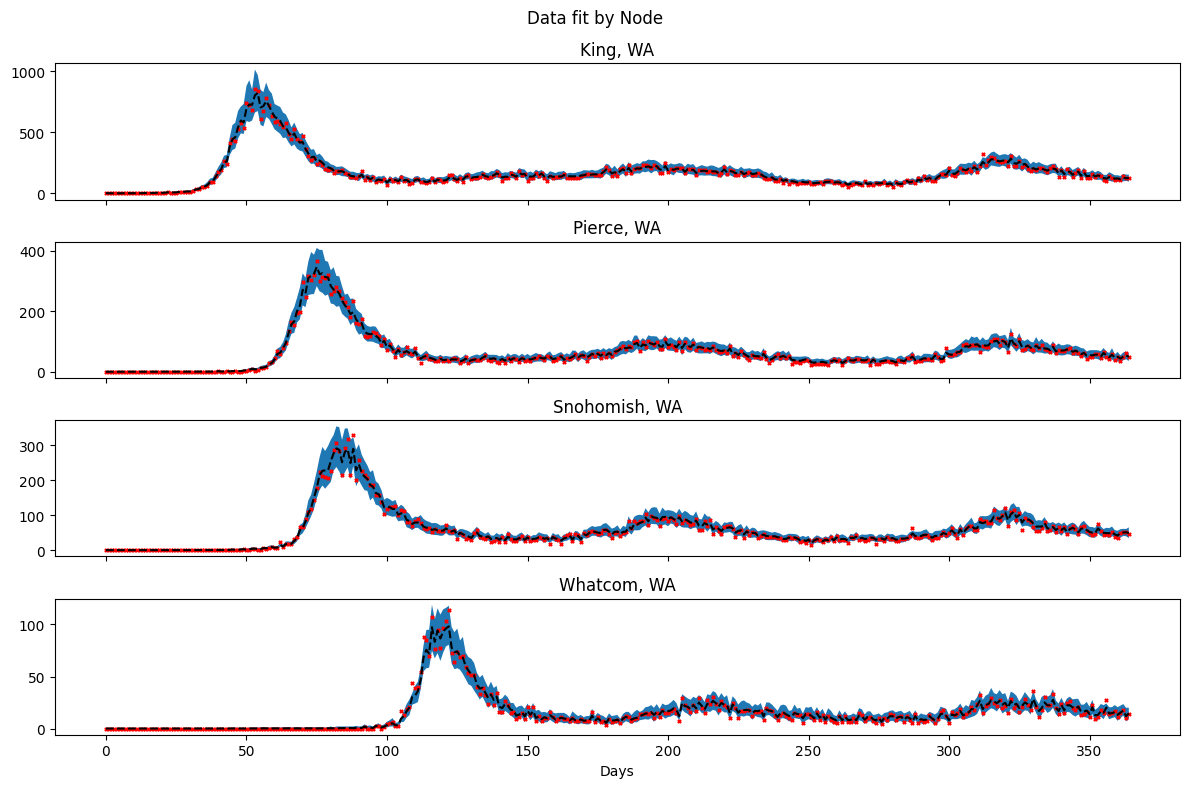

In [ ]:
import matplotlib.pyplot as plt

t_range = np.arange(pf_rume.time_frame.duration_days)

fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)


plt.suptitle('Data fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(particle_filter_output.posterior_values[:,:,node,:],97.5,axis = 1)[:,0]
        lower = np.percentile(particle_filter_output.posterior_values[:,:,node,:],2.5,axis = 1)[:,0]
        data_mean = np.mean((particle_filter_output.posterior_values[:,:,node,:]),axis = 1)
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].plot(data_mean,'--',label = 'mean',color = 'black')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].scatter(t_range,real_data[:,node],marker = 'x',color = 'red',s= 5)
ax[-1].set_xlabel('Days')
fig.tight_layout()


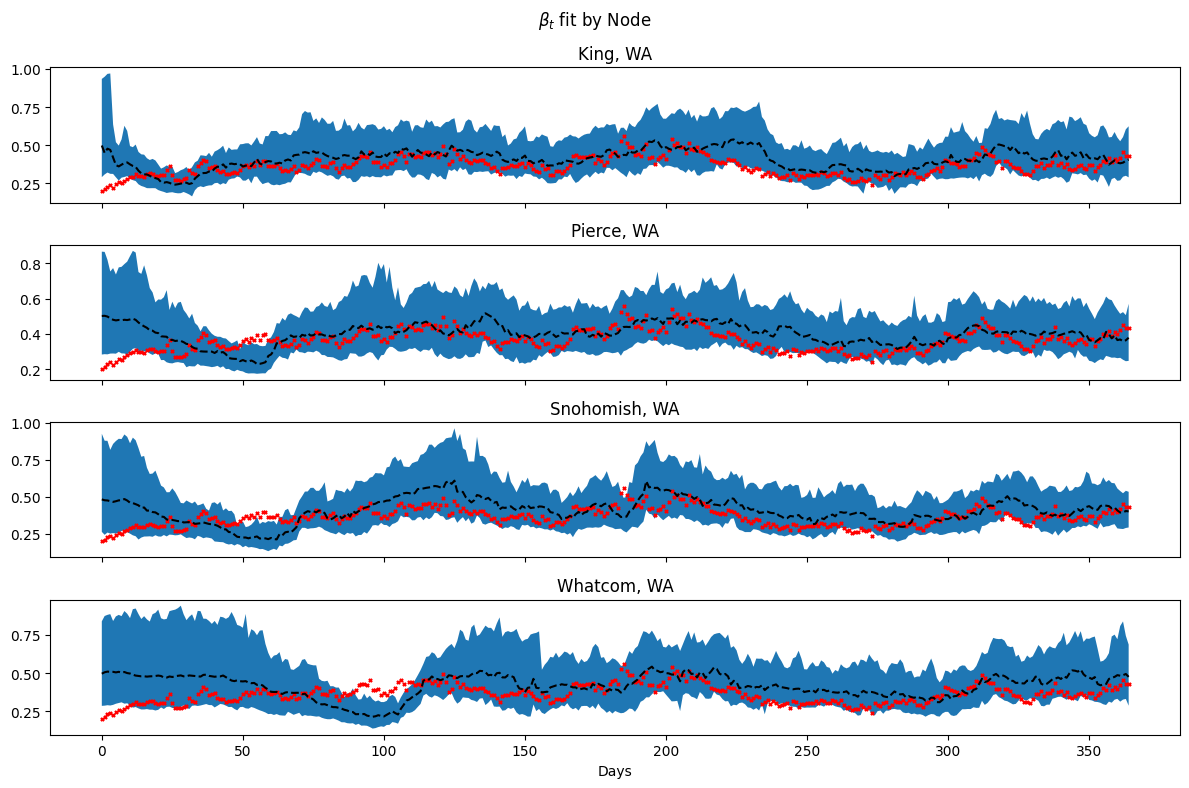

In [ ]:
fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

plt.suptitle('$\\beta_t$ fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(np.exp(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:,:,node]),97.5,axis = 0)
        lower = np.percentile(np.exp(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:,:,node]),2.5,axis = 0)
        beta_mean = np.exp(np.mean((particle_filter_output.estimated_params[NamePattern.of("log_beta")][:,:,node]),axis = 0))
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].plot(beta_mean,'--',label = 'mean',color = 'black')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].scatter(t_range,beta,marker = 'x',color = 'red',s= 5)
        
ax[-1].set_xlabel('Days')
fig.tight_layout()


In [ ]:
'''(num_realizations, tau_steps*num_days, num_nodes, num_compartments)'''
real_states = out.compartments
real_states = real_states.reshape(sim_time_frame.duration_days,2,4,4).sum(axis = 1)
pf_states = particle_filter_output.compartments
pf_states = pf_states.reshape(num_realizations,sim_time_frame.duration_days,2,4,4).sum(axis = 2)
print(pf_states.shape)

(100, 365, 4, 4)


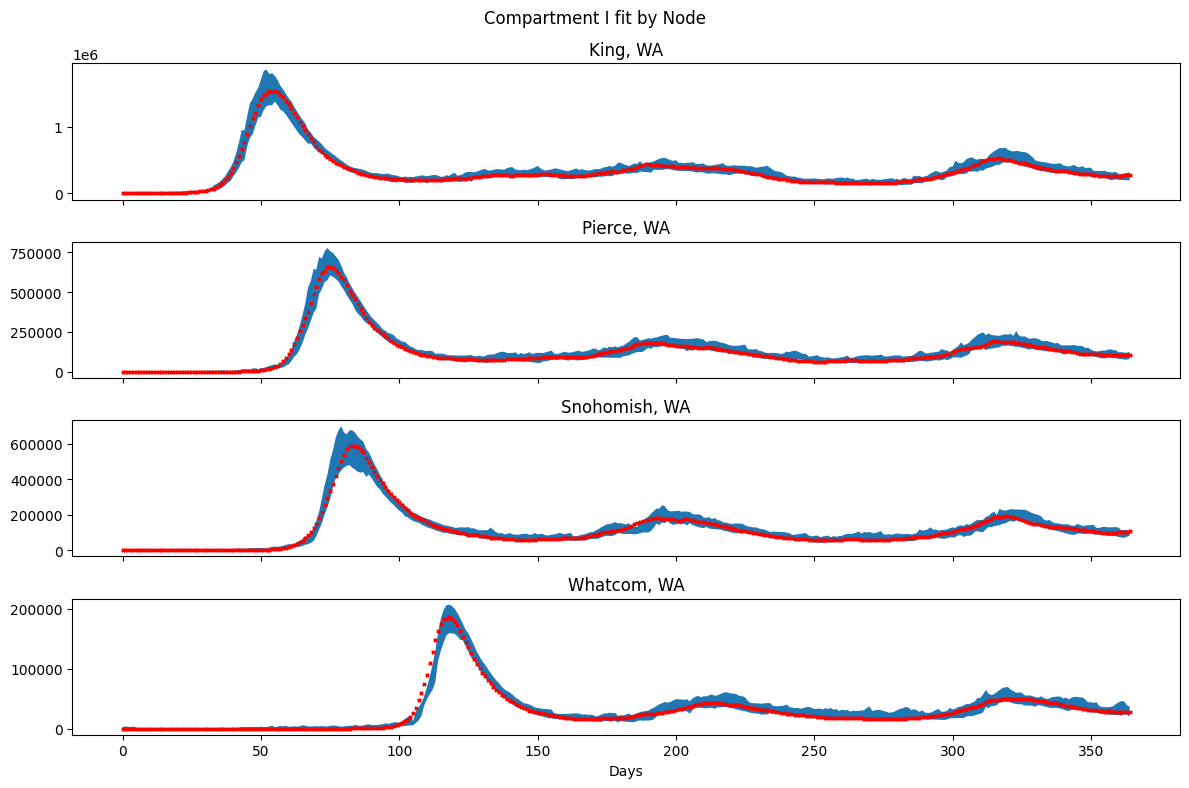

In [ ]:
t_range = np.arange(pf_rume.time_frame.duration_days)

fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

plt.suptitle('Compartment I fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(pf_states[:,:,node,1],97.5,axis = 0)
        lower = np.percentile(pf_states[:,:,node,1],2.5,axis = 0)
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].scatter(t_range,real_states[:,node,1],marker = 'x',color = 'red',s=5)
ax[-1].set_xlabel('Days')
fig.tight_layout()

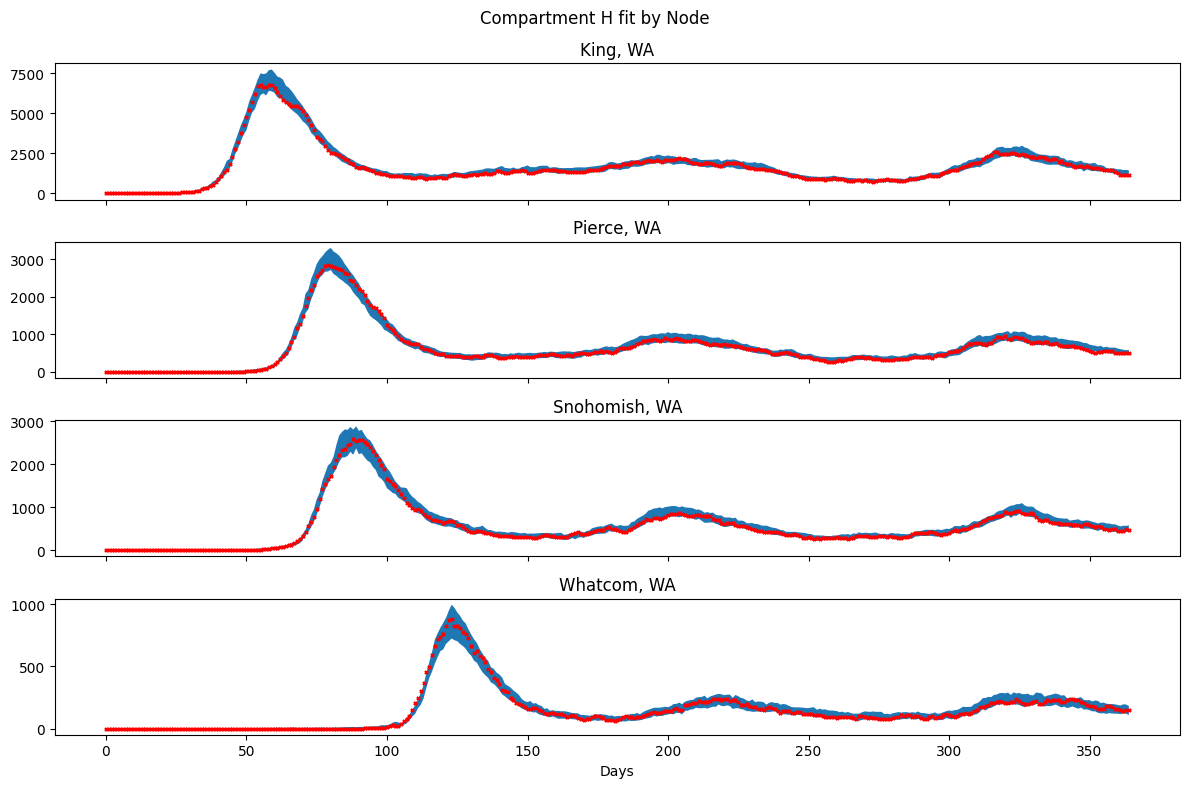

In [ ]:
t_range = np.arange(pf_rume.time_frame.duration_days)

fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

plt.suptitle('Compartment H fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(pf_states[:,:,node,3],97.5,axis = 0)
        lower = np.percentile(pf_states[:,:,node,3],2.5,axis = 0)
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].scatter(t_range,real_states[:,node,3],marker = 'x',color = 'red',s=5)
ax[-1].set_xlabel('Days')
fig.tight_layout()

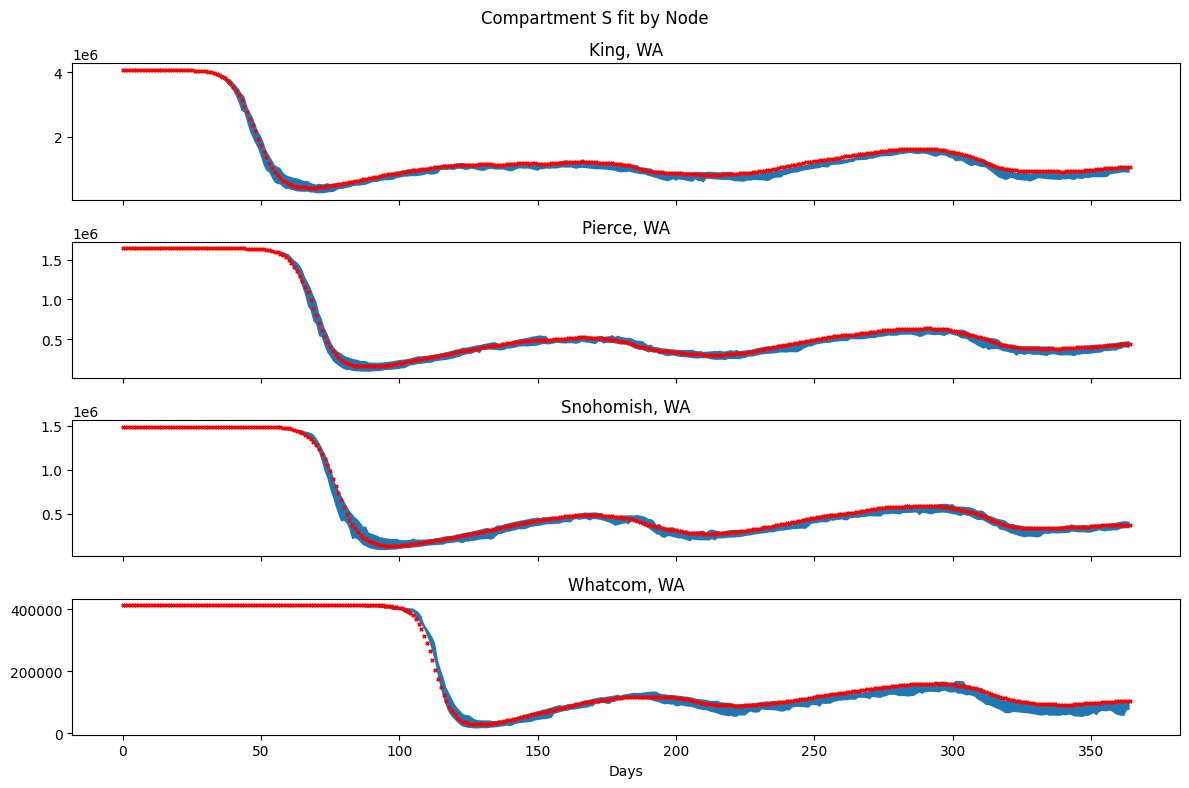

In [ ]:
t_range = np.arange(pf_rume.time_frame.duration_days)

fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)

plt.suptitle('Compartment S fit by Node')
for node in range(pf_rume.scope.nodes):
        upper = np.percentile(pf_states[:,:,node,0],97.5,axis = 0)
        lower = np.percentile(pf_states[:,:,node,0],2.5,axis = 0)
        ax[node].set_title(f'{pf_rume.scope.labels[node]}')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].scatter(t_range,real_states[:,node,0],marker = 'x',color = 'red',s=5)
ax[-1].set_xlabel('Days')
fig.tight_layout()